(1429, 68)
(1429, 87)
(1429, 68)
(71, 68)
Iter 1000, Minibatch Loss= 0.35,training err= 0.04,validating err= 0.26
Iter 2000, Minibatch Loss= 0.31,training err= 0.08,validating err= 0.10
Iter 3000, Minibatch Loss= 0.22,training err= 0.04,validating err= 0.10
Iter 4000, Minibatch Loss= 0.24,training err= 0.08,validating err= 0.06
Iter 5000, Minibatch Loss= 0.24,training err= 0.04,validating err= 0.04
Iter 6000, Minibatch Loss= 0.20,training err= 0.02,validating err= 0.06
Iter 7000, Minibatch Loss= 0.15,training err= 0.02,validating err= 0.18
Iter 8000, Minibatch Loss= 0.17,training err= 0.02,validating err= 0.06
Iter 9000, Minibatch Loss= 0.29,training err= 0.08,validating err= 0.12
Testing err of subtract true : 0.098591566
Accuracy is 90.14084339141846
Optimization Finished!


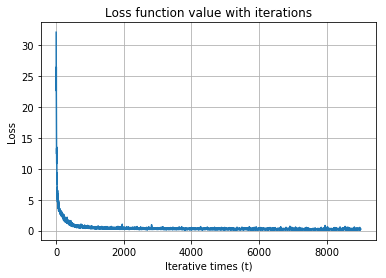

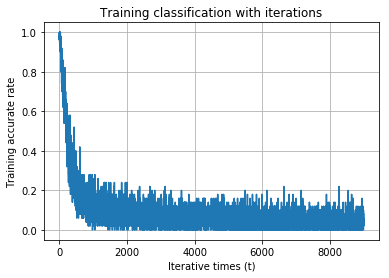

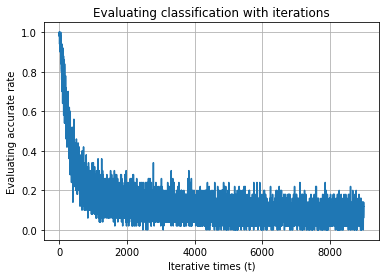

90.14084339141846


In [3]:
import time
start_time = time.time()
import pandas as pd
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from io import BytesIO
from functools import partial 
from IPython.display import clear_output, Image, display, HTML  
import scipy.io as sio 
import time  
import re

# parameters 
patience = 12
n_classes=87 
fault_type = 2; # 0--Tp; 1--LG; 2--LLG; 3--LL
impe_type = 2; # 1~4 fault impedance increases
model_name ='Test_results'#'NN_locate_30'#'NN_locate_half' 'NN_locate_full' 
# parameters for CNN 
lambda_loss_amount = 0.001
learning_rate = 0.001
training_iters =9000
batch_size =50
display_step = 1000 
decay_c =0.9
times = 1
buses =68                     
rootPath = '../01_datasets/Iu_feature' 
trainName ='Line_faults_train'   
testName = 'Line_faults_test' +'_type_' + str(fault_type) + '_'+str(impe_type)
evalName = 'Line_faults_eval' 
data = sio.loadmat(os.path.join(rootPath, trainName))
linedata = data['line']   

def load_data(w,path,name): 
    global times, buses
    import scipy.io as sio 
    PathName = os.path.join(path, name)
    data=sio.loadmat(PathName); 
    dV= data['dV_feature'] 
    Y_ad= data['Y'] 
    train_data = (Y_ad[:,w] @ dV[w,:]).imag.T   
    train_labels = data['y_num'] 
    col, buses = np.shape(train_data)  
    train_x = np.float64(np.reshape(train_data, (int(col/times), buses)))  
    train_y = np.zeros((int(col/times), n_classes))
    for i in range(int(col/times)):
        train_y[i,train_labels[0][i] ] = 1;
    return train_x, train_y ,col


def choose_w(line, thres):
    global buses
    all_freq =np.zeros((1,buses))
    for i in range( buses):
        ifreq = size(np.where(line[:,0] == i+1 )) + size(np.where(line[:,1] == i+1))
        all_freq[0][i] = ifreq
    w = [i for i in range(buses) if all_freq[0][i] >thres]  
    return w

# load data
def load_all_data(w):
    global train_data, train_labels, train_num, test_data, test_labels, test_num, eval_data, eval_labels, eval_num,samples,buses, times 
    train_data, train_labels, train_num = load_data(w,rootPath, trainName)  
    eval_data, eval_labels,eval_num= load_data(w,rootPath, evalName)  
    test_data, test_labels,test_num= load_data(w,rootPath, testName)   
    print (np.shape(train_data))
    print (np.shape(train_labels))
    print (np.shape(eval_data))
    print (np.shape(test_data))  
def input_weight_all(Theta,name):# Theta is a list type
    import pickle
    filepointer=open(name,"wb")
    pickle.dump(Theta,filepointer,protocol=2)
    filepointer.close()
    return 

def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var) 
def NN_net(x,y ): # weights are dictionaries
    global buses, times  
    layer1 = int(buses/2); layer2 = int(layer1/2); layer3 = int(layer2/2); layer4 = int(layer3/2)
    with tf.variable_scope('NN1'):
        w1= tf.get_variable('w1',shape=[ buses, layer1],
               initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))  
        b1=tf.get_variable( 'b1',
          shape = [layer1],
          initializer=tf.constant_initializer(0.0)) 
        # fully connected layer 
        fc1 =  tf.nn.relu(tf.add(tf.matmul(x, w1), b1))
    with tf.variable_scope('NN2'):
        w2= tf.get_variable('w2',shape=[ layer1, layer2],
               initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))  
        b2=tf.get_variable( 'b2',
          shape = [layer2],
          initializer=tf.constant_initializer(0.0)) 
        # fully connected layer 
        fc2 =  tf.nn.relu(tf.add(tf.matmul(fc1, w2), b2)) 
    with tf.variable_scope('Out'):
        wout= tf.get_variable('wout',shape=[ layer2,n_classes],
               initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))  
        bout=tf.get_variable( 'bout',
          shape = [n_classes],
          initializer=tf.constant_initializer(0.0)) 
        # fully connected layer 
        fout =   tf.add(tf.matmul(fc2, wout), bout)  
    return fout

def establish_model(): 
    global  learning_rate, training_iters,display_step,batch_size,patience 
    global buses, times, train_data, train_labels, eval_data, eval_labels, test_data, test_labels
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, buses ])
    y = tf.placeholder(tf.int32, [None, n_classes])   
    pred = NN_net(  x, y ) 
    y_score = tf.nn.softmax(pred)
    predict_op=tf.argmax(tf.nn.softmax(pred), 1)  
    # Define loss and optimizer 
    with tf.name_scope('loss'):   
        l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() ) 
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))+l2  
    with tf.name_scope('Optimizer'):  
        optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate , decay=decay_c).minimize(cost) 
    with tf.name_scope('err'): 
        correct = tf.equal(predict_op, tf.argmax(y, 1))
        err=1- tf.reduce_mean(tf.cast(correct, tf.float32))  
    tf.summary.scalar('err',err)
    tf.summary.scalar('loss',cost)
    
    #save
    saver = tf.train.Saver()
    # Launch the graph
    sess = tf.InteractiveSession()
    # Merge all the summaries and write them out  
    merged = tf.summary.merge_all()
    #train_writer = tf.summary.FileWriter('./train', sess.graph)
    #test_writer = tf.summary.FileWriter('./test') 
    #train_writer.add_graph(sess.graph)
    # training
    step=1
    loss_list=[]
    train_rate=[]
    eval_rate=[]
    n_incr_num =0
    best_loss = np.Inf 
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    while step < training_iters:
        ind = np.arange(train_data.shape[0])
        batch_idx = np.random.choice(ind, batch_size, replace=False) # the replace means not allow to pick up the same element again
        batch_x = train_data[batch_idx] 
        batch_y= train_labels[batch_idx] 
        indeval = np.arange(eval_data.shape[0]) 
        eval_idx = np.random.choice(indeval, batch_size, replace=False)
        batch_xeval=eval_data[eval_idx] 
        batch_yeval=eval_labels[eval_idx] 
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x,  y: batch_y }) 
        loss, train_err = sess.run([cost, err], feed_dict={x: batch_x,  y: batch_y  })
        loss_eval,eval_err=sess.run([cost ,err ], feed_dict={x: batch_xeval, y: batch_yeval })
        loss_list.append(loss)
        train_rate.append(train_err)
        eval_rate.append(eval_err)
        step += 1
        if step % display_step == 0:
            # Calculate batch loss and err 
            print("Iter " + str(step ) + ", Minibatch Loss= " +  "{:.2f}".format(loss) + ",training err= " + "{:.2f}".format(train_err)+ ",validating err= " + "{:.2f}".format(eval_err))   
            #print ('learning_rate is', learning_rate.eval())
            if loss_eval < best_loss:
                best_loss = loss_eval
                n_incr_num =0
            else:
                n_incr_num+=1
            if (n_incr_num >= patience) and (step > 7000):
                print ('Early_stopping! and the iterations is', step)
                # Create the collection.
                tf.get_collection("validation_nodes")
                # Add stuff to the collection.
                tf.add_to_collection("validation_nodes", x)  
                tf.add_to_collection("validation_nodes", y) 
                tf.add_to_collection("validation_nodes", y_score) 
                results = predict_op
                #save_path = saver.save(sess, "./train/"+model_name)
                correct_results_true, results_true=sess.run([correct, predict_op] , feed_dict={x:test_data, y:test_labels }) 
                total_test_true=sess.run(err , feed_dict={x:test_data,   y:test_labels })  
                print("Testing err :", total_test_true) 
                print ('Accuracy is', 100*(1-total_test_true))
                print ('Early Stop!')
                return loss_list,step,train_rate,eval_rate, correct_results_true, results_true, total_test_true
    # Create the collection.
    tf.get_collection("validation_nodes")
    # Add stuff to the collection.
    tf.add_to_collection("validation_nodes", x)   
    tf.add_to_collection("validation_nodes", y) 
    tf.add_to_collection("validation_nodes", y_score) 
    #save_path = saver.save(sess, "./train/"+model_name)
    correct_results_true, results_true=sess.run([correct, predict_op] ,  feed_dict={x:test_data, y:test_labels }) 
    total_test_true=sess.run(err , feed_dict={x:test_data,   y:test_labels })           
    print("Testing err of subtract true :", total_test_true) 
    print ('Accuracy is', 100*(1-total_test_true))
    print("Optimization Finished!") 
    return loss_list,step,train_rate,eval_rate, correct_results_true, results_true, total_test_true  
def each_perform(correct_results,eval_labels ):
    label_y=eval_labels#np.argmax(eval_labels,1)
    acc_rate = np.zeros((1,n_classes ))
    for i in range(n_classes):
        location = np.where(label_y == i)  
        correct = [correct_results[j] for j in location[0]]  
        if len(correct) > 0:
            acc_rate[0][i] = 100*np.mean(correct)  
    return acc_rate

def plot_loss(loss,train_step,from_second,name_save, plot_name,plot_title):
    if from_second :
        plt.plot(range(0,train_step-1,1),loss[1:])
    else:
        plt.plot(range(0,train_step,1),loss[0:])
    plt.xlabel('Iterative times (t)')
    plt.ylabel(plot_name)
    plt.title(plot_title)
    plt.grid(True)
    plt.savefig(name_save)
    plt.show()
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))    


def main():
    thres =4 
    w = choose_w(linedata, thres)
    w = np.r_[w, 23,42,61,51,57,6,37,58,45,26,10,33,4,41,8]  
    load_all_data(w)
    loss,step,train_rate,eval_rate, correct_results_true, results_true, total_test_true  =establish_model()  
    plot_loss(loss,step-1,False,"Loss_value.png", 'Loss','Loss function value with iterations') 
    plot_loss(train_rate,step-1,False,"Train_err_rate.png",'Training accurate rate','Training classification with iterations')
    plot_loss(eval_rate,step-1,False,"Eval_err_rate.png",'Evaluating accurate rate','Evaluating classification with iterations')  
    total_acc= (100*(1-total_test_true))
    print (total_acc)
    show_graph(tf.get_default_graph().as_graph_def()) 
    
if __name__ == '__main__':
    main()
 